RandomForest Model - MSE: 43.51388221391677, R-squared: 0.43887871940252776, MAE: 5.619610625882867


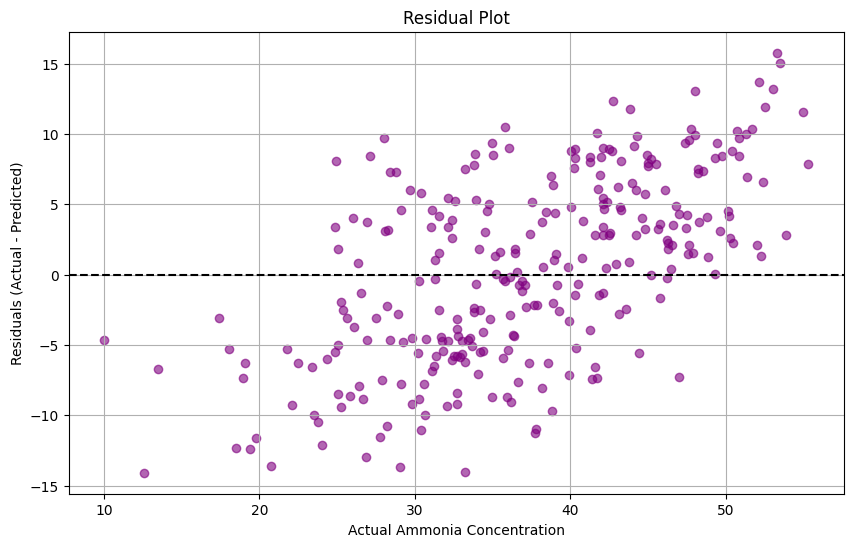

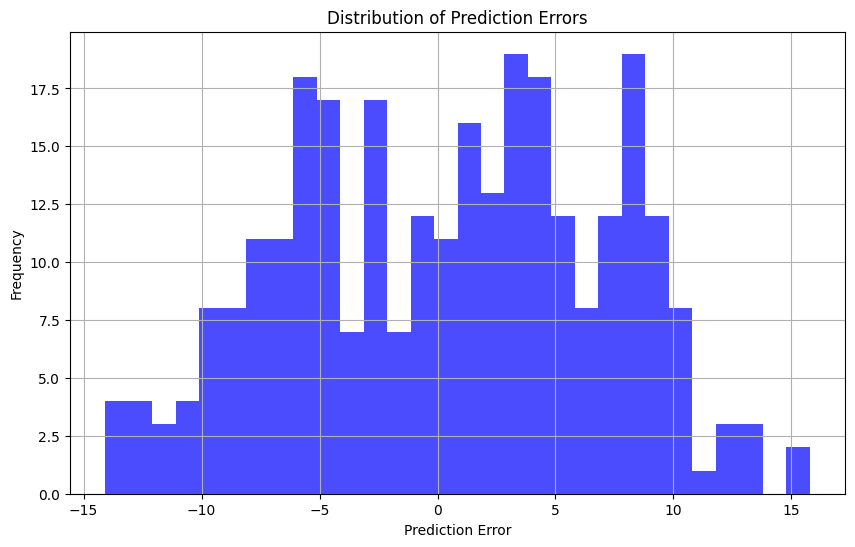

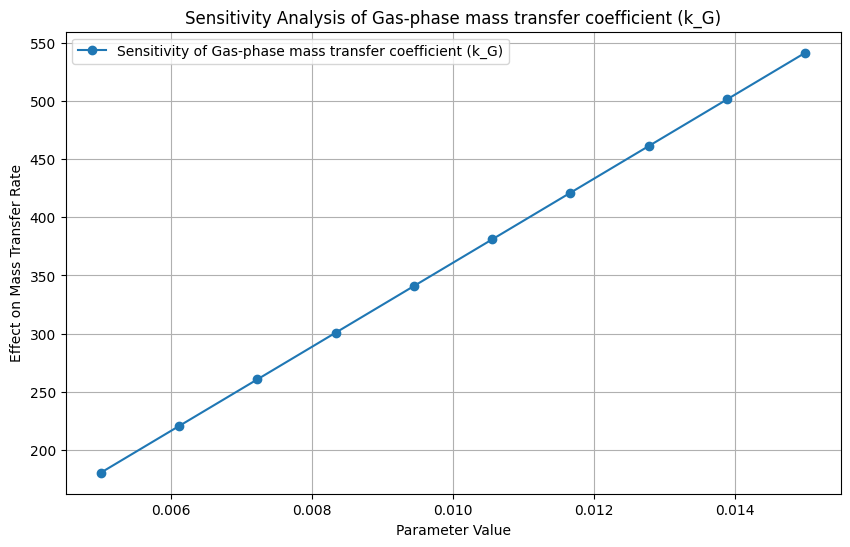

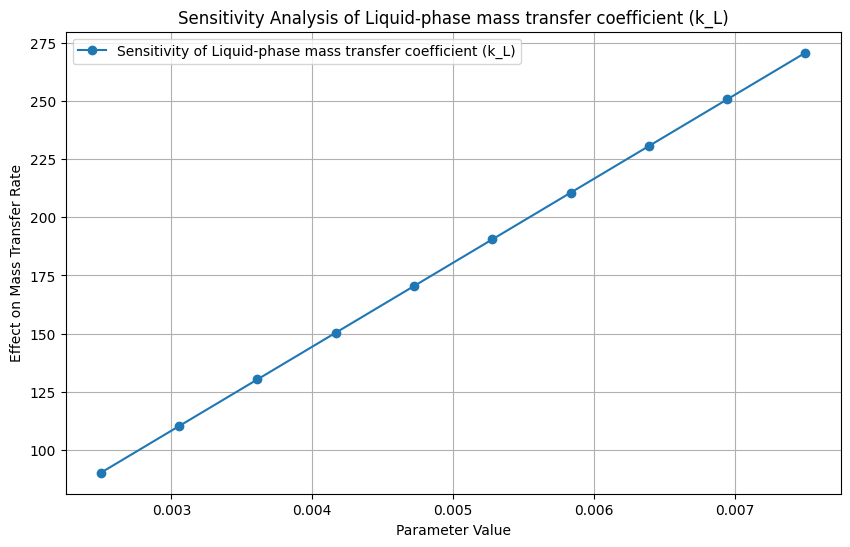

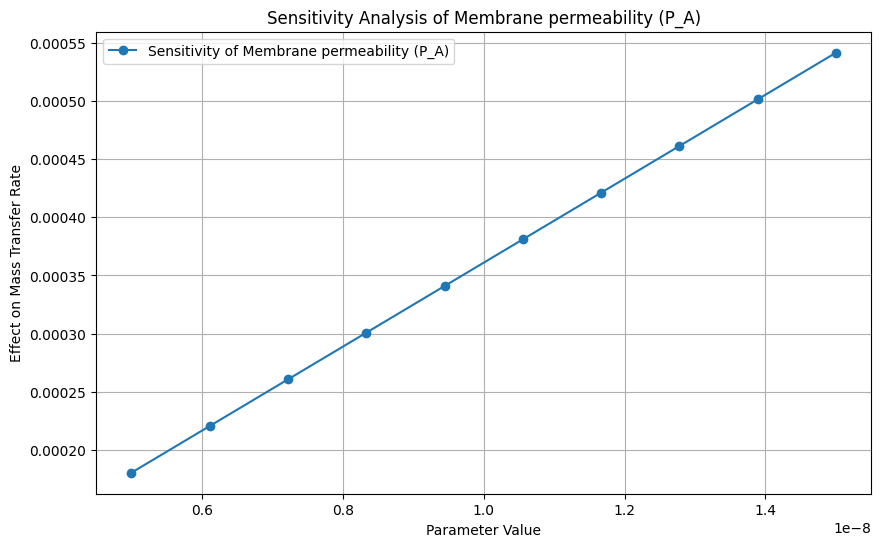

interactive(children=(FloatSlider(value=0.01, description='k_G', max=0.07, min=0.001, step=0.001), FloatSlider…

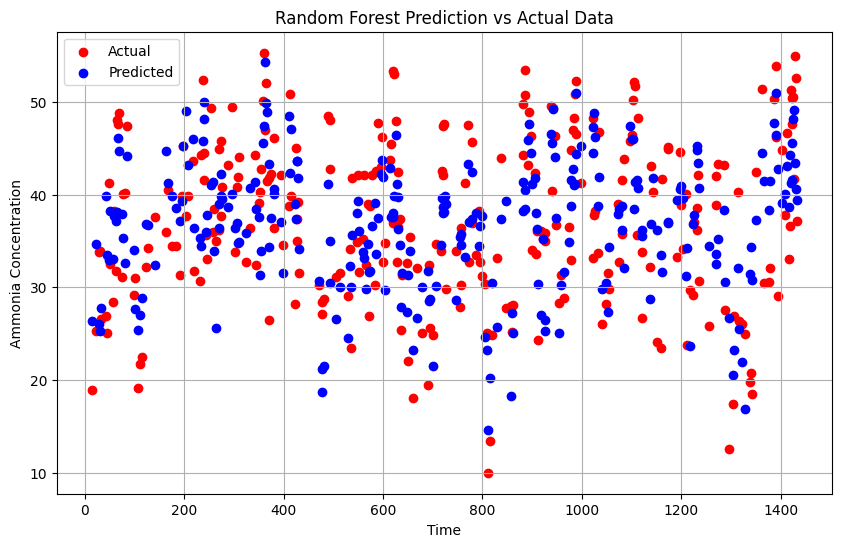

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load dataset
df = pd.read_csv("ammonia.csv")
df['Time'] = np.arange(len(df))  

# Defining features and target
X = df[['Time']]
y = df['Ammonia']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  RandomForest Model
model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation of model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RandomForest Model - MSE: {mse}, R-squared: {r2}, MAE: {mae}")

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Actual Ammonia Concentration")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid()
plt.show()

# Histogram of Prediction Errors
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid()
plt.show()

# Define mass transfer constants
H = 0.034   # Henry's law constant (mol/m³·Pa)
P_A = 1e-8  # Membrane permeability (mol/m·s·Pa)
L = 0.001   # Membrane thickness (m)

# Mass transfer equations used 
def absorption_process(C_A, k_G, H):
    return k_G * (C_A - H)

def membrane_separation(C_A, P_A, L):
    return (P_A * C_A) / L

def stripping_process(C_A, k_L, H):
    return k_L * (C_A - H)

# Sensitivity Analysis
def sensitivity_analysis(param_name, param_values, base_func, C_A):
    results = []
    for value in param_values:
        results.append(base_func(C_A, value, H) if param_name in ['k_G', 'k_L'] else base_func(C_A, value, L))
    return np.array(results)

params = {
    "Gas-phase mass transfer coefficient (k_G)": np.linspace(0.5 * 0.01, 1.5 * 0.01, 10),
    "Liquid-phase mass transfer coefficient (k_L)": np.linspace(0.5 * 0.005, 1.5 * 0.005, 10),
    "Membrane permeability (P_A)": np.linspace(0.5 * P_A, 1.5 * P_A, 10)
}

for param_label, values in params.items():
    param_key = param_label.split()[0]  # Extract k_G, k_L, or P_A
    results = sensitivity_analysis(param_key, values, absorption_process if param_key == "k_G" else stripping_process if param_key == "k_L" else membrane_separation, df['Ammonia'].mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(values, results, marker='o', linestyle='-', label=f'Sensitivity of {param_label}')
    plt.xlabel("Parameter Value")
    plt.ylabel("Effect on Mass Transfer Rate")
    plt.title(f"Sensitivity Analysis of {param_label}")
    plt.legend()
    plt.grid()
    plt.show()

# Interactive slider plots
def plot_parameters(k_G=0.01, k_L=0.005):
    df['Absorption_Rate'] = absorption_process(df['Ammonia'], k_G, H)
    df['Membrane_Flux'] = membrane_separation(df['Ammonia'], P_A, L)
    df['Stripping_Rate'] = stripping_process(df['Ammonia'], k_L, H)
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time'], df['Absorption_Rate'], label='Absorption Rate', color='blue')
    plt.plot(df['Time'], df['Membrane_Flux'], label='Membrane Flux', color='red')
    plt.plot(df['Time'], df['Stripping_Rate'], label='Stripping Rate', color='green')
    plt.xlabel("Time")
    plt.ylabel("Rates")
    plt.legend()
    plt.title("Effect of Mass Transfer Parameters")
    plt.grid()
    plt.show()

interact(plot_parameters, k_G=(0.001, 0.07, 0.001), k_L=(0.001, 0.09, 0.001))

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='red', label='Actual')
plt.scatter(X_test, y_pred, color='blue', label='Predicted')
plt.xlabel("Time")
plt.ylabel("Ammonia Concentration")
plt.legend()
plt.title("Random Forest Prediction vs Actual Data")
plt.grid()
plt.show()

# results
df['Predicted_Concentration'] = model.predict(X)
df.to_csv("ammonia_predictions.csv", index=False)

